# Análisis de las vecindades de los píxeles tras la transformación LBP

En primer lugar se realiza la carga de la imagen sobre la que se va a realizar el proceso y se indican los parámetros seleccionados.

In [1]:
from preprocess.preprocess import *
import PARAMETERS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from confusion_matrix_pretty_print import print_confusion_matrix
from main import init_clf_and_fit
import zipfile

%matplotlib inline

PARAMETERS.LBP_METHOD = 'default'
PARAMETERS.METHOD = 'get_pyramid_dataset'
PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
PARAMETERS.BALANCE = False
PARAMETERS.N_SCALES = 5
PARAMETERS.GRAY_INTENSITY = True
PARAMETERS.X2SCALE = True
PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
PARAMETERS.PLOT = False

pd.DataFrame({k: getattr(PARAMETERS, k) for k in VALID_PARAMETERS.keys()}, index=['Parameters']).head()

,LBP_METHOD,METHOD,INTERPOLATION_ALGORITHM,BALANCE,N_SCALES,GRAY_INTENSITY,X2SCALE
Parameters,default,get_pyramid_dataset,lanczos,False,5,True,True


In [2]:
np.random.seed(0)
kernel_list = [np.round(np.random.uniform(low=-1, high=1, size=(9,)).reshape(3, 3), 3) for _ in range(5)]
kernel_list += [np.round(np.random.uniform(low=-1, high=1, size=(25,)).reshape(5, 5), 3) for _ in range(5)]

In [3]:
from create_db import main
from joblib import Parallel, delayed


def convolution_features(kernel):
    PARAMETERS.LBP_METHOD = 'default'
    PARAMETERS.METHOD = 'get_pyramid_dataset'
    PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
    PARAMETERS.BALANCE = False
    PARAMETERS.N_SCALES = 5
    PARAMETERS.GRAY_INTENSITY = True
    PARAMETERS.X2SCALE = True
    PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
    PARAMETERS.PLOT = False
    PARAMETERS.CONVOLUTION = kernel
    PARAMETERS.CONV_PATH = PARAMETERS.update_convolution_path(PARAMETERS)
    main()
    return f"../DB/extra_features/convolution/{PARAMETERS.CONV_PATH}"
    
    
paths = Parallel(n_jobs=5)(delayed(convolution_features)(kernel) for kernel in kernel_list)

/home/fer/Drive/Estudios/Master-IA/TFM/lbp-pyramid/preprocess/preprocess.py:104: RuntimeWarning: invalid value encountered in true_divide
  img = np.round((img/np.max(img)) * 255).astype(np.int8)


In [5]:
from pathlib import Path

for i, path in enumerate(paths):
    train_path = list(Path(path).glob('train_train*'))[0]
    test_path = list(Path(path).glob('train_test*'))[0]
    if i == 0:
        df_train_convolutions = pd.read_pickle(train_path, compression='gzip')
        df_train_convolutions.drop(['label'], axis=1, inplace=True)
        df_train_convolutions.columns = [col + '_' + path.split('/')[-1] for col in df_train_convolutions.columns]
        df_test_convolutions = pd.read_pickle(test_path, compression='gzip')
        df_test_convolutions.drop(['label'], axis=1, inplace=True)
        df_test_convolutions.columns = [col + '_' + path.split('/')[-1] for col in df_test_convolutions.columns]
    else:
        df_temp = pd.read_pickle(train_path, compression='gzip')
        df_temp.drop(['label'], axis=1, inplace=True)
        df_temp.columns = [col + '_' + path.split('/')[-1] for col in df_temp.columns]
        df_train_convolutions = pd.concat([df_train_convolutions, df_temp], axis=1)
        df_temp = pd.read_pickle(test_path, compression='gzip')
        df_temp.drop(['label'], axis=1, inplace=True)
        df_temp.columns = [col + '_' + path.split('/')[-1] for col in df_temp.columns]
        df_test_convolutions = pd.concat([df_test_convolutions, df_temp], axis=1)

In [6]:
df_train_convolutions

,Original_0.098;0.43;0.206;0.09;-0.153;0.292;-0.125;0.784;0.927,1:1_0.098;0.43;0.206;0.09;-0.153;0.292;-0.125;0.784;0.927,1:2_0.098;0.43;0.206;0.09;-0.153;0.292;-0.125;0.784;0.927,1:4_0.098;0.43;0.206;0.09;-0.153;0.292;-0.125;0.784;0.927,1:8_0.098;0.43;0.206;0.09;-0.153;0.292;-0.125;0.784;0.927,2:1_1_0.098;0.43;0.206;0.09;-0.153;0.292;-0.125;0.784;0.927,2:1_2_0.098;0.43;0.206;0.09;-0.153;0.292;-0.125;0.784;0.927,2:1_3_0.098;0.43;0.206;0.09;-0.153;0.292;-0.125;0.784;0.927,2:1_4_0.098;0.43;0.206;0.09;-0.153;0.292;-0.125;0.784;0.927,Original_-0.233;0.583;0.058;0.136;0.851;-0.858;-0.826;-0.96;0.665,...,2:1_4_0.451;0.003;0.912;0.288;-0.152;0.213;-0.962;-0.397;0.32;-0.42;0.236;-0.142;-0.729;-0.403;0.14;0.182;0.149;0.306;0.304;-0.137;0.793;-0.265;-0.128;0.784;0.612,Original_0.408;-0.8;0.839;0.428;0.998;-0.701;0.736;-0.675;0.231;-0.752;0.696;0.615;0.138;-0.186;-0.862;0.395;-0.093;0.444;0.733;0.951;0.712;-0.977;-0.28;0.46;-0.657,1:1_0.408;-0.8;0.839;0.428;0.998;-0.701;0.736;-0.675;0.231;-0.752;0.696;0.615;0.138;-0.186;-0.862;0.395;-0.093;0.444;0.733;0.951;0.712;-0.977;-0.28;0.46;-0.657,1:2_0.408;-0.8;0.839;0.428;0.998;-0.701;0.736;-0.675;0.231;-0.752;0.696;0.615;0.138;-0.186;-0.862;0.395;-0.093;0.444;0.733;0.951;0.712;-0.977;-0.28;0.46;-0.657,1:4_0.408;-0.8;0.839;0.428;0.998;-0.701;0.736;-0.675;0.231;-0.752;0.696;0.615;0.138;-0.186;-0.862;0.395;-0.093;0.444;0.733;0.951;0.712;-0.977;-0.28;0.46;-0.657,1:8_0.408;-0.8;0.839;0.428;0.998;-0.701;0.736;-0.675;0.231;-0.752;0.696;0.615;0.138;-0.186;-0.862;0.395;-0.093;0.444;0.733;0.951;0.712;-0.977;-0.28;0.46;-0.657,2:1_1_0.408;-0.8;0.839;0.428;0.998;-0.701;0.736;-0.675;0.231;-0.752;0.696;0.615;0.138;-0.186;-0.862;0.395;-0.093;0.444;0.733;0.951;0.712;-0.977;-0.28;0.46;-0.657,2:1_2_0.408;-0.8;0.839;0.428;0.998;-0.701;0.736;-0.675;0.231;-0.752;0.696;0.615;0.138;-0.186;-0.862;0.395;-0.093;0.444;0.733;0.951;0.712;-0.977;-0.28;0.46;-0.657,2:1_3_0.408;-0.8;0.839;0.428;0.998;-0.701;0.736;-0.675;0.231;-0.752;0.696;0.615;0.138;-0.186;-0.862;0.395;-0.093;0.444;0.733;0.951;0.712;-0.977;-0.28;0.46;-0.657,2:1_4_0.408;-0.8;0.839;0.428;0.998;-0.701;0.736;-0.675;0.231;-0.752;0.696;0.615;0.138;-0.186;-0.862;0.395;-0.093;0.444;0.733;0.951;0.712;-0.977;-0.28;0.46;-0.657
0,251,255,255,241,224,225,224,1,1,0,...,255,1,1,31,17,17,239,231,1,1
1,251,239,255,241,224,241,225,17,1,0,...,239,2,1,31,17,17,225,225,1,0
2,252,239,255,241,224,97,1,0,255,0,...,239,3,1,31,17,17,160,241,21,1
3,252,239,255,241,224,1,1,239,239,0,...,225,3,1,31,17,17,225,225,1,1
4,252,238,255,241,224,1,16,238,254,0,...,225,3,1,31,17,17,241,224,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226537,2,22,30,31,16,16,17,30,30,4,...,1,5,16,16,13,1,255,254,1,0
226538,2,30,30,31,16,1,16,31,30,4,...,0,5,17,16,13,1,255,0,16,22
226539,2,30,30,15,16,22,30,30,30,4,...,16,5,1,255,0,1,16,16,30,30
226540,2,30,30,15,16,30,30,30,30,4,...,17,5,0,255,0,1,16,16,30,30


In [ ]:
#main.main(lgb=True, plot_once=True, extra_features={'train': df_train_convolutions, 'test': df_test_convolutions})

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


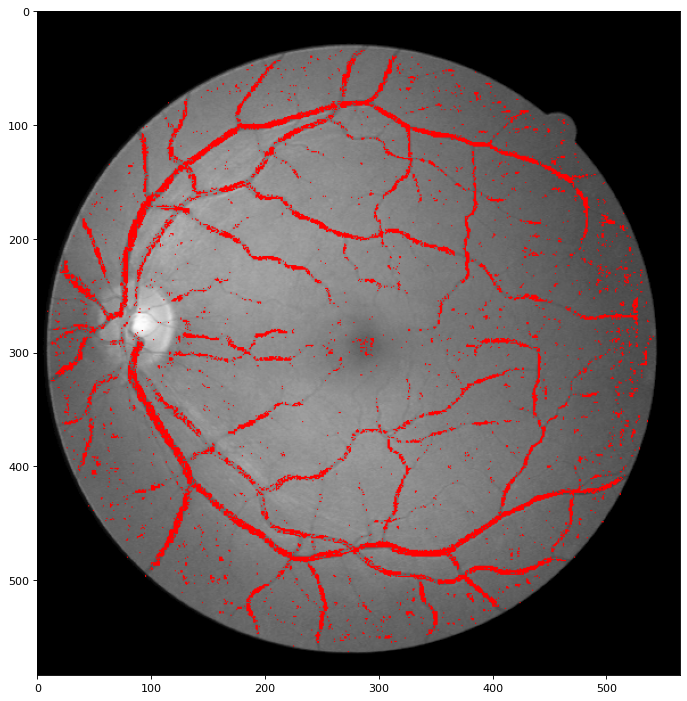

Accuracy score: 0.9072463853198083

F1 score: 0.5528685943922853

Confusion matrix:

     t/p      0     1 
        0 1158168 29377 
        1 97019 78143 
Sensivity: 0.44611845034882
Specificity: 0.9752624111086317


(0.907, 0.553, 1158168, 29377, 97019, 78143)

In [9]:
from main import *

PARAMETERS.LBP_METHOD = 'default'
PARAMETERS.METHOD = 'get_pyramid_dataset'
PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
PARAMETERS.BALANCE = False
PARAMETERS.N_SCALES = 5
PARAMETERS.GRAY_INTENSITY = True
PARAMETERS.X2SCALE = True
PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
PARAMETERS.PLOT = True

PARAMETERS.CONVOLUTION = None
main(lgb='Num', plot_once=True)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.317078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


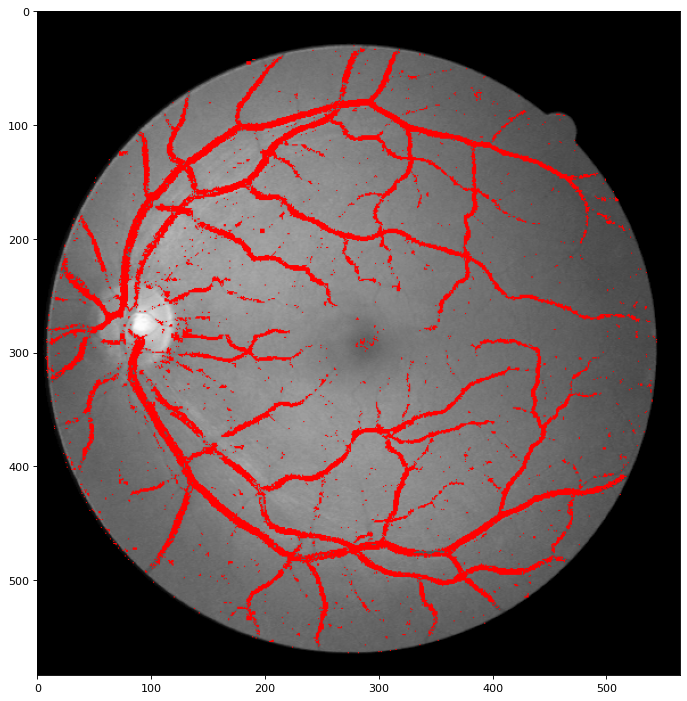

Accuracy score: 0.9281987984210839

F1 score: 0.6999000116550831

Confusion matrix:

     t/p      0     1 
        0 1150766 36779 
        1 61065 114097 
Sensivity: 0.6513798654959408
Specificity: 0.9690293841496532


(0.928, 0.7, 1150766, 36779, 61065, 114097)

In [10]:
main(lgb='Num', plot_once=True, extra_features={'train': df_train_convolutions, 'test': df_test_convolutions})

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.404796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


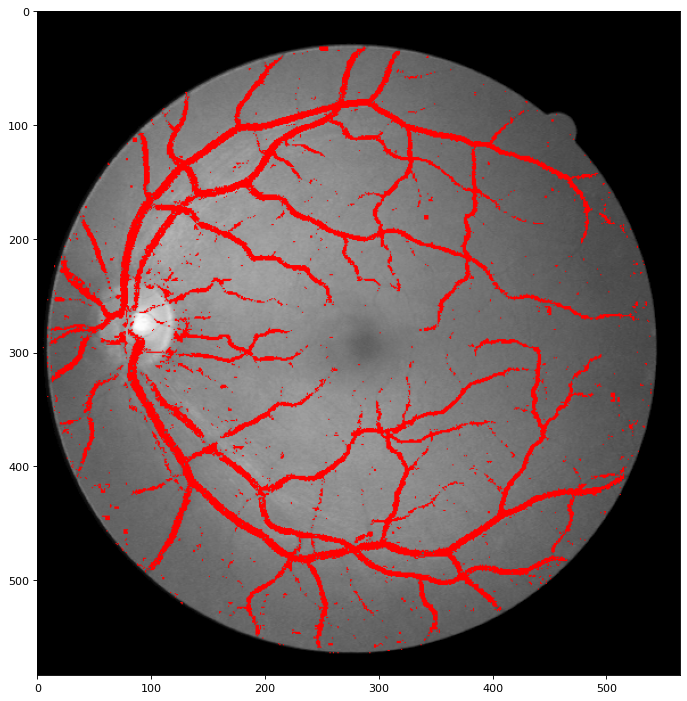

Accuracy score: 0.9310431369325908

F1 score: 0.7229716981132075

Confusion matrix:

     t/p      0     1 
        0 1146123 41422 
        1 52546 122616 
Sensivity: 0.7000148434021077
Specificity: 0.9651196375716289


(0.931, 0.723, 1146123, 41422, 52546, 122616)

In [11]:
main(lgb='Num', plot_once=True, extra_features={'train': df_train_convolutions, 'test': df_test_convolutions}, all_lbp=True)